<a href="https://colab.research.google.com/github/tomonari-masada/course-nlp2020/blob/master/11_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# トピックモデリングの実践

* トピックモデリングを、NMF(nonnegative matrix factorization)とLDA(latent Dirichlet allocation)とで実践してみる。
 * LDAの理屈については「統計モデリング２」で。
* いずれもsklearnの実装を使う。
* 各トピックの上位単語はワードクラウドで可視化する。

* 参考資料
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

## 11-01 データセットの準備
* NeurIPSで発表された1,740本の論文の本文を使う。

### データをダウンロードしリスト化する関数を定義

In [3]:
# import io
# import os.path
# import re
# import tarfile
# import smart_open
 
# # PATH = 'result0604.csv' 
# PATH = './'


# def extract_documents(url='https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz'):

#   fname = os.path.join(PATH, url.split('/')[-1])

#   if not os.path.isfile(fname):
#     with smart_open.open(url, "rb") as fin:
#       with smart_open.open(fname, 'wb') as fout:
#         while True:
#           buf = fin.read(io.DEFAULT_BUFFER_SIZE)
#           if not buf:
#             break
#           fout.write(buf)

#   with tarfile.open(fname, mode='r:gz') as tar:
#   # Ignore directory entries, as well as files like README, etc.
#     files = [
#              m for m in tar.getmembers()
#              if m.isfile() and re.search(r'nipstxt/nips\d+/\d+\.txt', m.name)
#              ]
#     for member in sorted(files, key=lambda x: x.name):
#       member_bytes = tar.extractfile(member).read()
#       yield member_bytes.decode('utf-8', errors='replace')

* 実際にデータを取得しリスト化する

In [53]:
import pandas as pd
df = pd.read_csv("./result0605_tweet.csv")

type(df["text"])
docs = df["text"].to_list()

In [4]:
# docs = list(extract_documents())


* 文書数、具体的な文書の内容などを確認

In [54]:
print(len(docs))

151278


In [55]:
print(docs[0][:1000])

RT @rintaro_maro: 歴代興行収入1位記念🎉「鬼滅キャラがジブリの世界に行ったら」#鬼滅の刃無限列車編  #千と千尋 https://t.co/ZJWVE54rcn


### spaCyを使ってtokenizeする

* 前処理の高速化のためtaggerなどは無効にしておく

In [66]:
import spacy

nlp = spacy.load('en', disable=["tagger", "parser", "ner"])

from transformers import BertJapaneseTokenizer

tknz = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese')



/opt/conda/lib/python3.7/site-packages/graphql/type/directives.py:55: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  assert isinstance(locations, collections.Iterable), 'Must provide locations for directive.'
/opt/conda/lib/python3.7/site-packages/graphql/type/directives.py:62: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  assert isinstance(args, collections.Mapping), '{} args must be a dict with argument names as keys.'.format(name)
/opt/conda/lib/python3.7/site-packages/graphql/type/typemap.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import OrderedDict, Sequence, defaultdict


* 小文字にしてからtokenizeする関数の定義

In [70]:
# def spacy_lemmatize_text(nlp, text):
#   text = tknz.tokenize(text.lower())
#   doc = [word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text]
#   return [word for word in doc if len(word) > 1] # 長さ1の単語は削除

tknz.tokenize(doc.lower())

['rt',
 '@',
 '3',
 'r',
 '##j',
 '##y',
 '6',
 'g',
 '##u',
 '9',
 'e',
 '##erc',
 '6',
 'ab',
 ':',
 'お',
 '久',
 '##し',
 '##ぶり',
 'です',
 '!!',
 '12',
 '時',
 'に',
 'あげる',
 'つもり',
 'です',
 'か',
 '少し',
 '...',
 '##「',
 '滅',
 '」',
 '#',
 '鬼',
 '滅',
 'の',
 '刃',
 '#',
 '鬼',
 '滅',
 'の',
 '刃',
 '無限',
 '列車',
 '編',
 '#',
 '煉',
 '##獄',
 '杏',
 '寿',
 '##郎',
 '#',
 'イラスト',
 '#',
 'コ',
 '##ピック',
 '#',
 '絵',
 '##描',
 '##き',
 'さん',
 'と',
 '繋がり',
 'たい',
 'http',
 '##s',
 '://',
 't',
 '.',
 'co',
 '/',
 'b',
 '##s',
 '42',
 'o',
 '##g',
 '6',
 'f',
 '##v',
 '##f']

* tokenizationの実行

In [67]:
from tqdm import tqdm

new_docs = list()
for doc in tqdm(docs):
  new_docs.append(tknz.tokenize(doc.lower()))

100%|██████████| 151278/151278 [00:56<00:00, 2664.95it/s]


* tokenizationの結果を確認

In [72]:
print(new_docs[0])

['rt', '@', 'r', '##int', '##ar', '##o', '_', 'm', '##ar', '##o', ':', '歴代', '興行', '収入', '1', '位', '記念', '[UNK]', '「', '鬼', '滅', 'キャラ', 'が', 'ジブ', '##リ', 'の', '世界', 'に', '行っ', 'たら', '」', '###', '鬼', '滅', 'の', '刃', '無限', '列車', '編', '#', '千', 'と', '千', '##尋', 'http', '##s', '://', 't', '.', 'co', '/', 'z', '##j', '##w', '##ve', '54', 'r', '##c', '##n']


* 各文書を長い文字列で表しなおす（CountVectorizerを後で使うため）

In [73]:
corpus = [' '.join(doc) for doc in new_docs]

In [74]:
corpus[0]

'rt @ r ##int ##ar ##o _ m ##ar ##o : 歴代 興行 収入 1 位 記念 [UNK] 「 鬼 滅 キャラ が ジブ ##リ の 世界 に 行っ たら 」 ### 鬼 滅 の 刃 無限 列車 編 # 千 と 千 ##尋 http ##s :// t . co / z ##j ##w ##ve 54 r ##c ##n'

## 11-02 データ行列の作成
* NMFの場合、TF-IDFで単語の重みを求めて各文書をベクトル化する。
* LDAの場合、単に単語の出現頻度を重みとして各文書をベクトル化する。

### sklearnのCountVectorizerで疎行列化する

* 全文書の半分より多い文書に現れる単語は、高頻度語とみなして削除する。
* 10件未満の文書にしか現れない単語は、低頻度語とみなして削除する。

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words='english')
X = vectorizer.fit_transform(corpus)

In [76]:
print(X[0])

  (0, 557)	1
  (0, 349)	2
  (0, 5065)	1
  (0, 5726)	1
  (0, 3868)	1
  (0, 5890)	1
  (0, 2052)	1
  (0, 2287)	1
  (0, 3316)	1
  (0, 5781)	1
  (0, 1342)	1
  (0, 873)	1
  (0, 230)	1


In [77]:
print(vectorizer.get_feature_names())

['00', '000', '001', '007', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '10000', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '1100', '111', '112', '113', '114', '115', '116', '117', '118', '12', '120', '1200', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '1300', '131', '132', '133', '136', '14', '140', '141', '143', '147', '148', '15', '150', '1500', '151', '152', '153', '155', '156', '157', '16', '160', '1600', '161', '163', '164', '165', '1650', '167', '17', '170', '171', '173', '177', '18', '180', '1800', '183', '185', '186', '189', '19', '190', '1900', '1911', '1917', '192', '193', '194', '196', '1971', '1981', '1984', '1985', '1989', '199', '1992', '1996', '1997', '1999', '20', '200', '2000', '2001', '2002', '2005', '2008', '2009', '201', '2010', '2011', '2013', '2015', '2017', '2018', '2019', '202', '2020', '203', '204', '205', '206', '21', '210', '211', '212', '213', '214', '215', '217'

In [78]:
print(len(vectorizer.get_feature_names()))

6426


* 文書数と語彙サイズを変数にセット

In [79]:
X.shape

(151278, 6426)

In [80]:
n_samples, n_features = X.shape

### TF-IDFで各文書における単語の重みを計算する

In [81]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xtfidf = tfidf.fit_transform(X)

In [82]:
print(Xtfidf[0])

  (0, 5890)	0.2331961443980187
  (0, 5781)	0.22202515495955544
  (0, 5726)	0.2044122444958422
  (0, 5065)	0.21479072577139283
  (0, 3868)	0.2040573218590239
  (0, 3316)	0.27416224415573653
  (0, 2287)	0.28426850792428743
  (0, 2052)	0.26115441350718094
  (0, 1342)	0.226580715685478
  (0, 873)	0.2761399635932355
  (0, 557)	0.2384650551254131
  (0, 349)	0.5242106846638344
  (0, 230)	0.2886795863302042


In [83]:
Xtfidf.shape

(151278, 6426)

* 抽出するトピックの個数は、今回は20個とする。

In [84]:
n_components = 20

## 11-03 NMFでトピック抽出
* まず、TF-IDFのデータ行列を使って　NMFによってトピック抽出を試みる。
 * NMFのパラメータ群は下記サンプルコードのまま。
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

### NMFとLDAのインポート

In [85]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

### NMFによるトピック抽出の実行

In [86]:
from time import time

print((f"Fitting the NMF model (generalized Kullback-Leibler "
  f"divergence) with tf-idf features, n_samples={n_samples} "
  f"and n_features={n_features}"))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5,
          verbose=1)
nmf.fit(Xtfidf)
print(f"done in {time() - t0:0.3f}s.")

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=151278 and n_features=6426
Epoch 10 reached after 9.351 seconds, error: 1810.469407
Epoch 20 reached after 18.205 seconds, error: 1807.079045
Epoch 30 reached after 27.068 seconds, error: 1806.093237
Epoch 40 reached after 36.003 seconds, error: 1805.683132
Epoch 50 reached after 44.901 seconds, error: 1805.434684
Epoch 60 reached after 53.774 seconds, error: 1805.256507
done in 56.081s.


* NMFにおける各コンポーネントは、それぞれのトピックにおける単語の重要度を表すベクトルとして表現されている。

In [87]:
nmf.components_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.89675291e-15, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.63509312e-02, 0.00000000e+00, 3.73107873e-03, ...,
        0.00000000e+00, 0.00000000e+00, 4.81983969e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### トピックの重要語を取り出す関数の定義

In [88]:
def get_top_words(model, feature_names, n_top_words=30):
  top_features = list()
  weights = list()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features.append([feature_names[i] for i in top_features_ind])
    weights.append(topic[top_features_ind])
  return top_features, weights

### NMFの各コンポーネントから重要語を取り出す

In [89]:
top_words, weights = get_top_words(nmf, vectorizer.get_feature_names())

In [90]:
print(top_words[0])

['ショー', 'ハラ', '会議', 'キリ', 'パワ', '格付け', 'より', 'mi', 'tt', '実写', 'ube', 'ob', 'ks', '終了', 'チェック', '笑っ', 'ack', 'al', '裏側', 'てる', 'ゲーム', 'ゲート', 'ゲージ', 'ゲー', '齋藤', 'コア', 'ゲン', 'ココ', 'コス', 'コスト']


In [91]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

In [92]:
topic_words[0]

{'ショー': 3.5847286035897015,
 'ハラ': 3.5492900256989626,
 '会議': 3.54618070170786,
 'キリ': 3.533446597567353,
 'パワ': 3.528896204255781,
 '格付け': 3.524505770365088,
 'より': 2.0552202683235263,
 'mi': 1.9807358740163525,
 'tt': 1.8787051328595017,
 '実写': 1.8647925304552941,
 'ube': 1.8615178884244388,
 'ob': 1.8445184923022644,
 'ks': 1.8374944440343703,
 '終了': 1.823947485204348,
 'チェック': 1.796255378854702,
 '笑っ': 1.7886374844893482,
 'ack': 1.781198169720984,
 'al': 1.7733457132655688,
 '裏側': 1.763626630596187,
 'てる': 1.515139309482898,
 'ゲーム': 0.0,
 'ゲート': 0.0,
 'ゲージ': 0.0,
 'ゲー': 0.0,
 '齋藤': 0.0,
 'コア': 0.0,
 'ゲン': 0.0,
 'ココ': 0.0,
 'コス': 0.0,
 'コスト': 0.0}

### 重要語をワードクラウドで可視化

In [93]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

* ワードクラウドから除去するストップワードを確認する。

In [94]:
print(STOPWORDS)

{"isn't", 'he', 'k', 'is', 'through', 'that', 'between', 'your', 'not', 'yourselves', 'from', "he'll", "he'd", "where's", 'been', 'or', 'myself', 'its', "when's", 'during', 'with', 'what', "wouldn't", "there's", 'could', 'www', 'again', 'my', 'an', 'does', 'can', 'having', 'had', 'ought', 'off', 'to', "what's", 'whom', 'being', "wasn't", 'then', 'any', 'some', "couldn't", 'are', 'should', 'their', "you'll", "aren't", 'own', "why's", "don't", "i'm", 'ours', 'how', 'which', 'be', "they've", "you're", "you've", 'was', "let's", 'hence', 'were', 'you', 'also', 'until', "they'll", "i've", "haven't", 'therefore', 'themselves', "he's", 'above', 'all', 'cannot', 'they', 'after', "who's", 'did', 'about', "you'd", 'very', 'nor', 'itself', 'few', 'more', 'she', "can't", 'just', "shan't", "shouldn't", "weren't", 'has', 'each', 'me', 'when', 'too', 'out', 'for', "she's", 'further', 'however', 'ourselves', 'than', 'his', "it's", 'else', 'only', 'am', 'because', 'both', 'i', 'in', 'our', 'a', 'up', 't

* ワードクラウドを描画

In [107]:
FONT_PATH = "/usr/share/fonts/opentype/ipaexfont-mincho/ipaexm.ttf"
cloud = WordCloud(stopwords=STOPWORDS,
                  font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

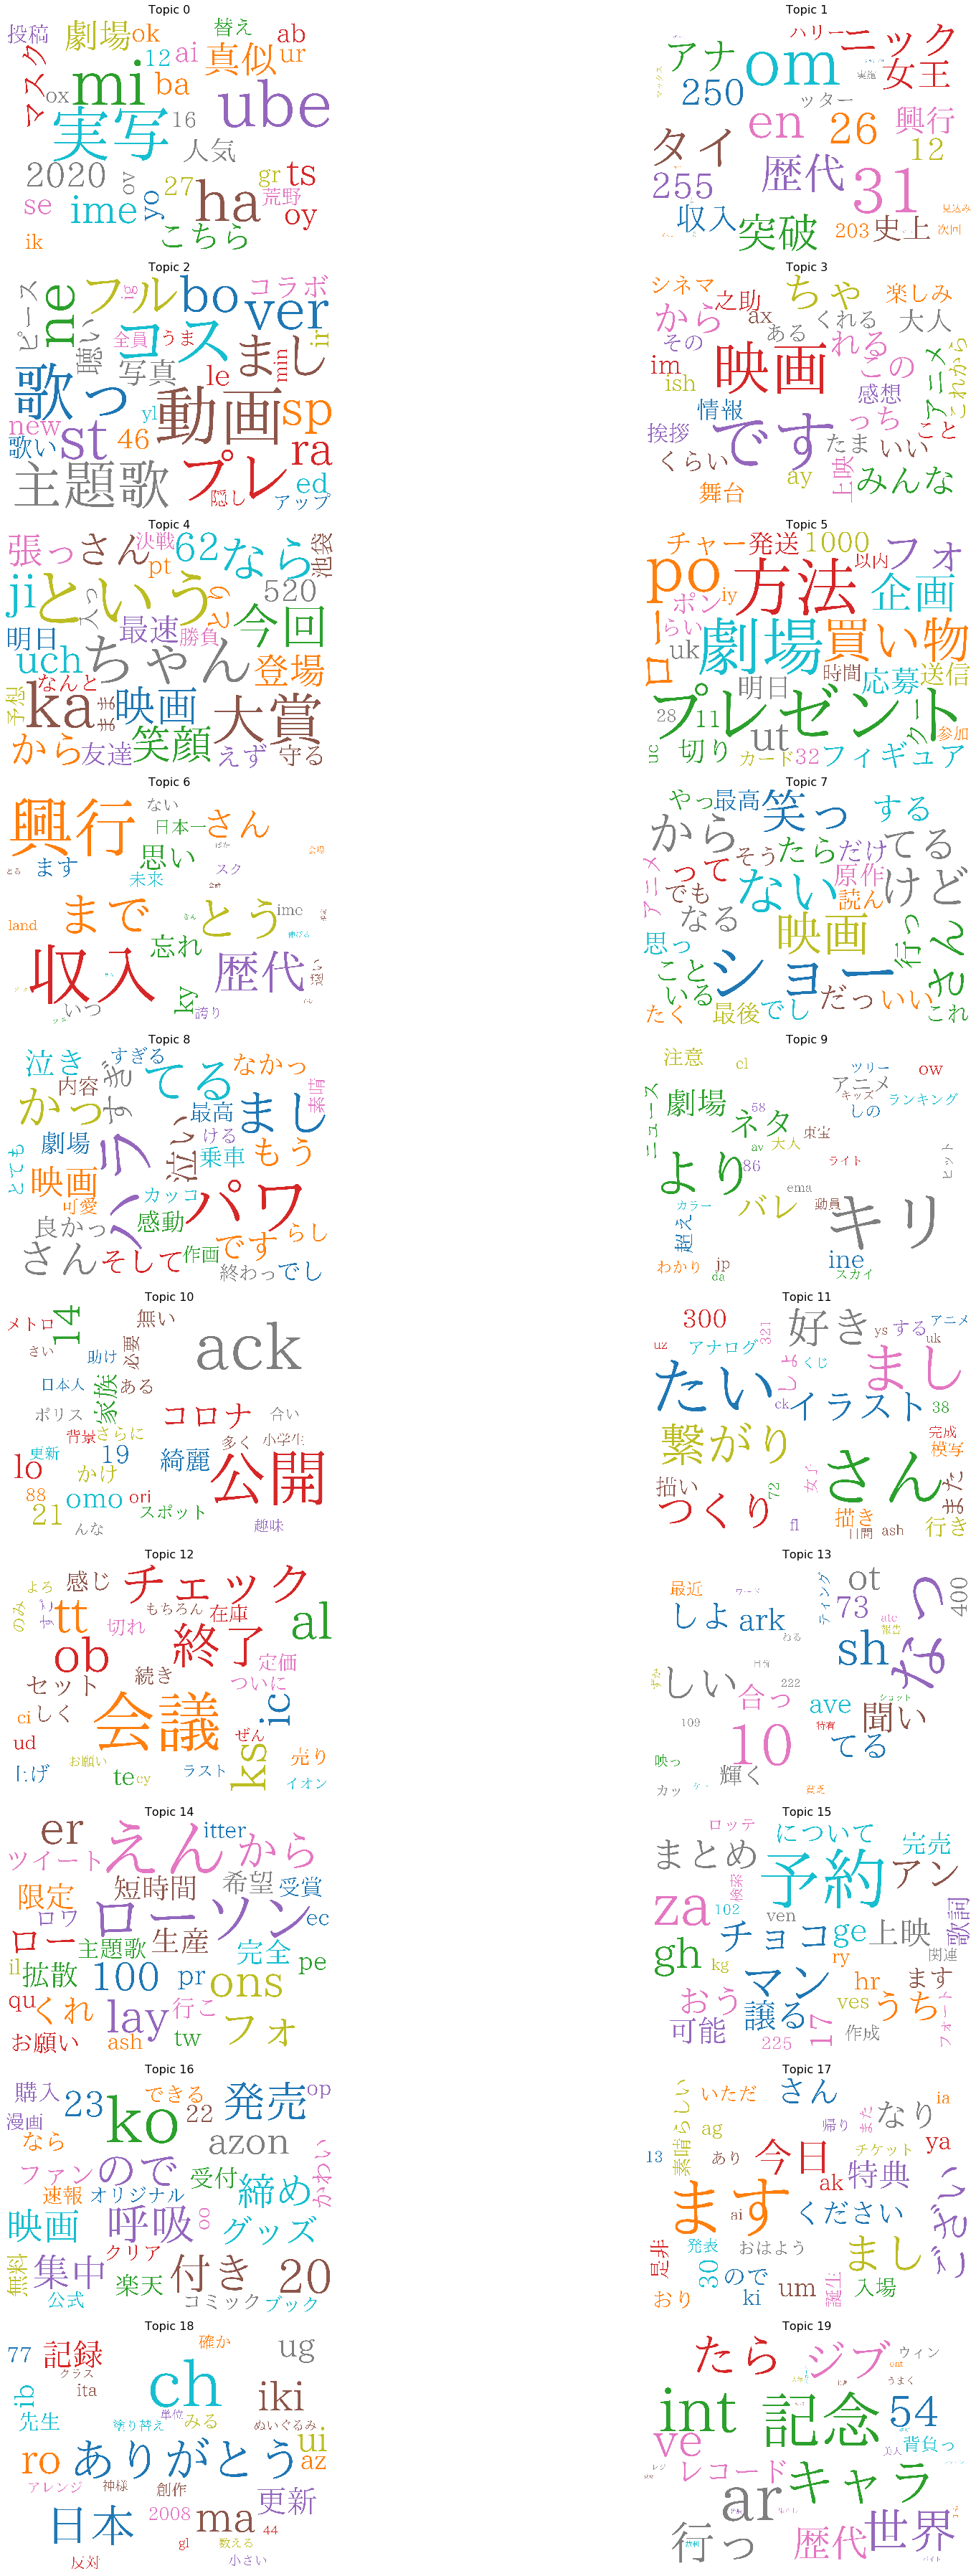

In [110]:
fig, axes = plt.subplots(10, 2, figsize=(32, 50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

## 11-04 LDAでトピック抽出

### LDAによるトピック抽出の実行

In [111]:
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=20,
                                topic_word_prior=0.01,
                                learning_method='online',
                                learning_offset=50,
                                batch_size=200,
                                mean_change_tol=1e-4,
                                random_state=1,
                                evaluate_every=1,
                                verbose=1)

TypeError: __init__() got an unexpected keyword argument 'font_path'

In [98]:
print((f"Fitting LDA models with tf features, "
  f"n_samples={n_samples} and n_features={n_features}"))
t0 = time()
lda.fit(X)
print(f"done in {time() - t0:0.3f}s.")

Fitting LDA models with tf features, n_samples=151278 and n_features=6426
iteration: 1 of max_iter: 20, perplexity: 18423.5329
iteration: 2 of max_iter: 20, perplexity: 16544.7155
iteration: 3 of max_iter: 20, perplexity: 15856.2591
iteration: 4 of max_iter: 20, perplexity: 15517.9276
iteration: 5 of max_iter: 20, perplexity: 15318.8312
iteration: 6 of max_iter: 20, perplexity: 15194.1304
iteration: 7 of max_iter: 20, perplexity: 15112.3131
iteration: 8 of max_iter: 20, perplexity: 15053.4236
iteration: 9 of max_iter: 20, perplexity: 15010.7741
iteration: 10 of max_iter: 20, perplexity: 14977.8538
iteration: 11 of max_iter: 20, perplexity: 14951.6648
iteration: 12 of max_iter: 20, perplexity: 14931.3985
iteration: 13 of max_iter: 20, perplexity: 14914.3851
iteration: 14 of max_iter: 20, perplexity: 14900.0689
iteration: 15 of max_iter: 20, perplexity: 14886.2843
iteration: 16 of max_iter: 20, perplexity: 14875.7373
iteration: 17 of max_iter: 20, perplexity: 14866.6117
iteration: 18 of 

### LDAの各トピックから高確率語を取り出す

In [99]:
top_words, weights = get_top_words(lda, vectorizer.get_feature_names())

In [100]:
print(top_words[0])

['ube', 'mi', '実写', 'ha', 'ime', 'ts', '真似', '劇場', '2020', 'こちら', 'ba', 'マスク', 'oy', 'se', 'yo', 'ai', '人気', 'ab', 'ur', '27', 'ok', 'gr', '12', 'ov', 'ox', '投稿', 'ik', '16', '替え', '荒野']


In [101]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

### 高確率語をワードクラウドで可視化

In [112]:
cloud = WordCloud(stopwords=STOPWORDS,
                                font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

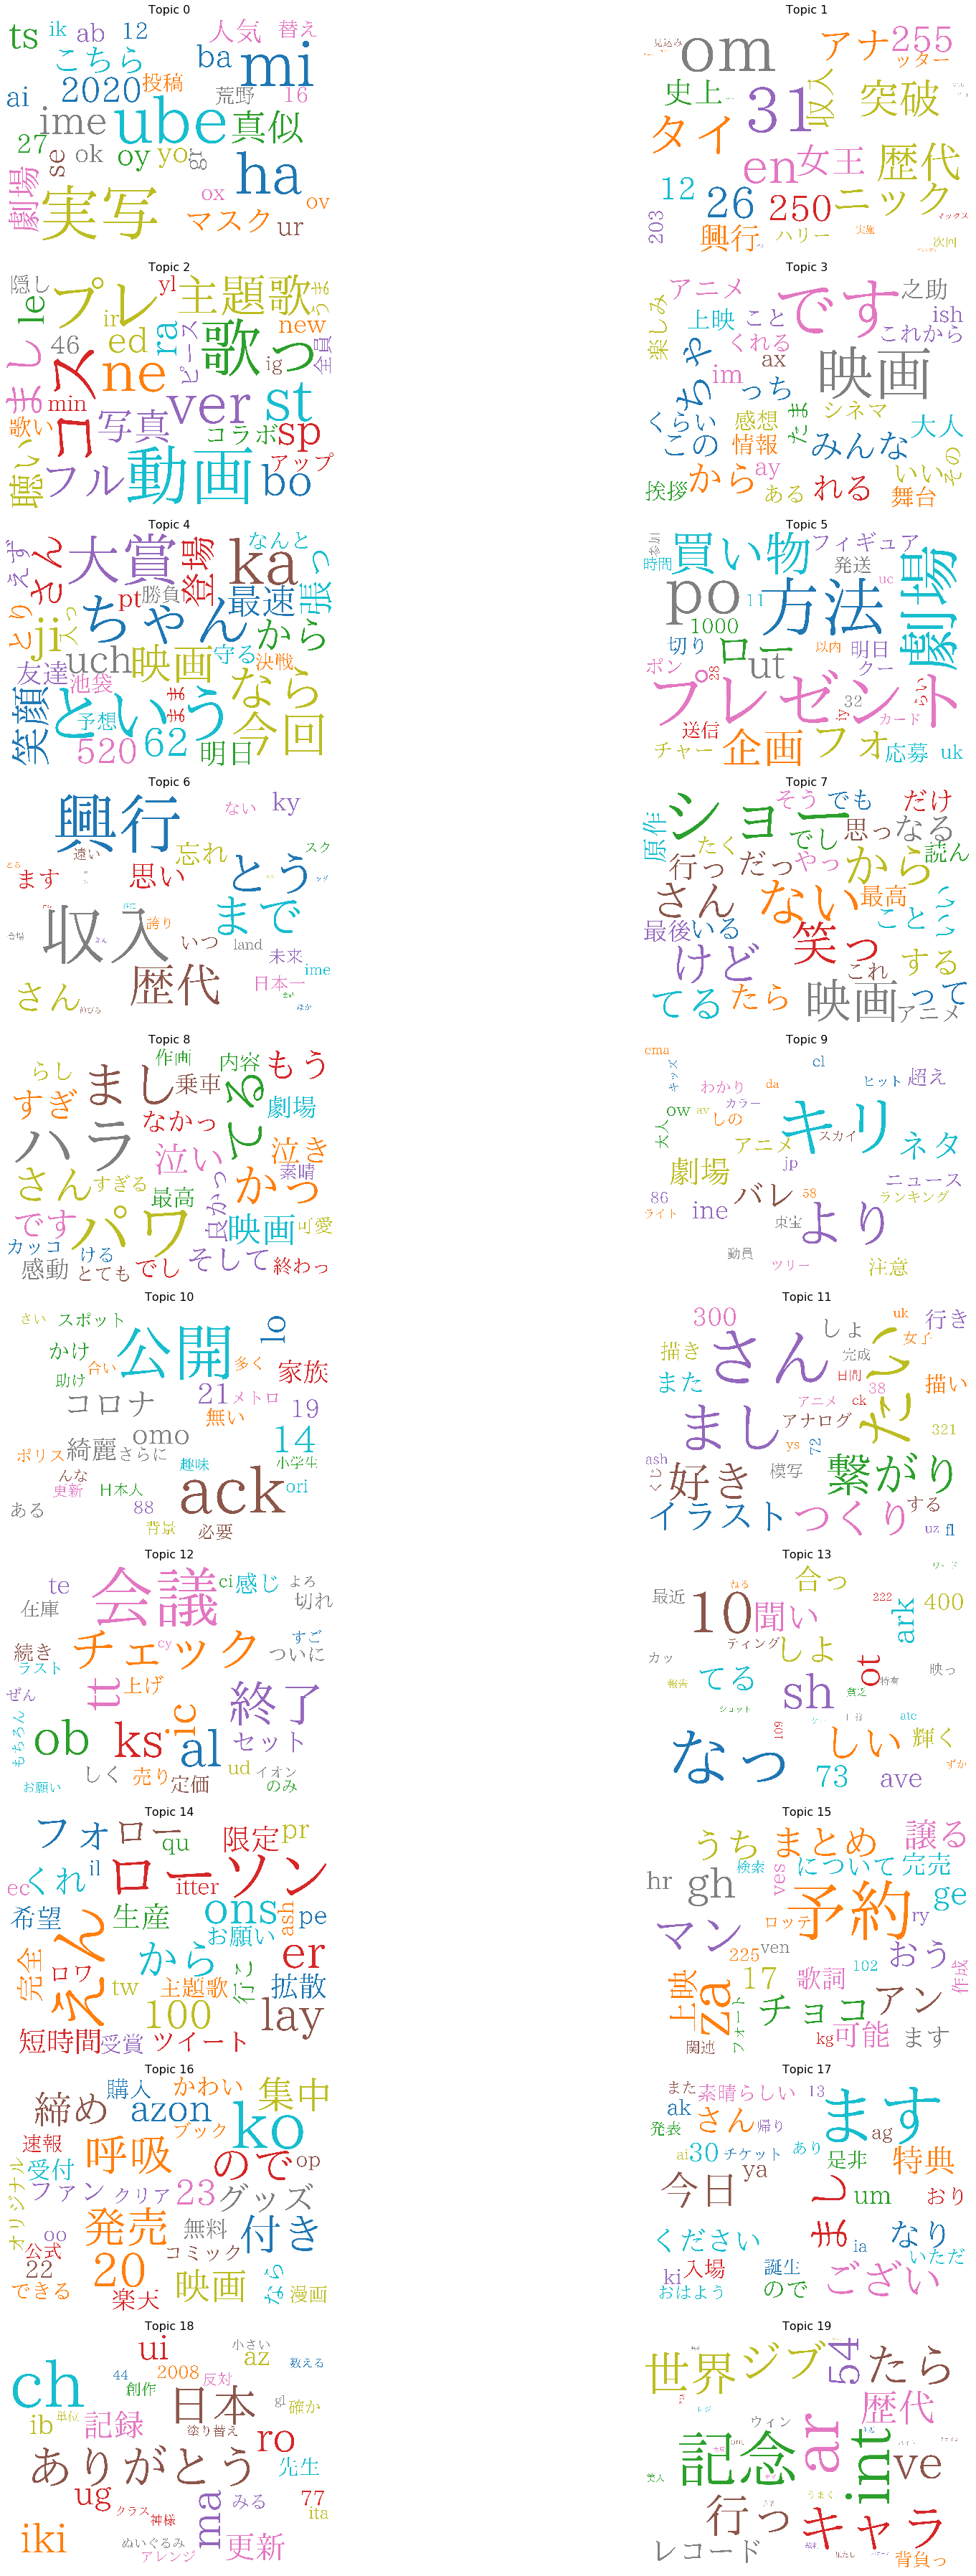

In [114]:
# fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)
fig, axes = plt.subplots(10, 2, figsize=(32, 50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

In [104]:
!pip install pyLDAvis

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [105]:
import pyLDAvis
import pyLDAvis.sklearn

In [106]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7      -10.878068   10.538728       1        1  18.568322
8      -60.884026  -75.591820       2        1  10.144487
3       -2.336119  -53.289074       3        1   8.183788
5      -61.385319  -12.914634       4        1   6.551022
0      -28.737743  126.296997       5        1   6.497800
11       1.066606 -123.552811       6        1   6.058402
12      45.140720   -7.947869       7        1   5.779606
17    -140.795975  -98.530548       8        1   5.021558
16      61.531681  -83.240562       9        1   4.400259
2      -72.563057 -140.396881      10        1   4.361891
14      15.984491   63.578186      11        1   4.080996
9     -160.851624   68.945145      12        1   3.566377
6       85.961830   51.922935      13        1   2.917857
4      -99.020836  109.936348      14        1   2.746474
19    -176.764130   -8.681684      15        1   2.570234
1     -117.189880  -37.420200      16        1   2.139360
10     108.829918  -22.946203      17        1   2.117434
18      47.588097  121.934814      18        1   1.618813
13    -106.467834   30.176889      19        1   1.584342
15     -50.613804   59.328842      20        1   1.090976, topic_info=     Term          Freq         Total Category  logprob  loglift
2059   キリ  25749.000000  25749.000000  Default  30.0000  30.0000
1217   さん  51121.000000  51121.000000  Default  29.0000  29.0000
3478   会議  23441.000000  23441.000000  Default  28.0000  28.0000
1631   ます  25463.000000  25463.000000  Default  27.0000  27.0000
1321   たい  22686.000000  22686.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
2401   ソー    119.951895    120.155459  Topic20  -5.4355   4.5164
2806  フォル    101.450389    101.653953  Topic20  -5.6030   4.5161
3278   上映    883.447385   2867.268535  Topic20  -3.4387   3.3408
794    ry    294.071873    882.622230  Topic20  -4.5388   3.4190
1631   ます    502.374661  25463.661330  Topic20  -4.0032   0.5924

[819 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
6         8  1.000409    03
9         8  0.999212    06
13       19  1.000023    10
14       11  0.999997   100
15        4  1.000012  1000
...     ...       ...   ...
6276      9  0.228390    限定
6276     11  0.771503    限定
6286     10  0.999454    隠し
6295      8  0.128995    集中
6295      9  0.871127    集中

[901 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 4, 6, 1, 12, 13, 18, 17, 3, 15, 10, 7, 5, 20, 2, 11, 19, 14, 16])